In [1]:
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import lax

from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


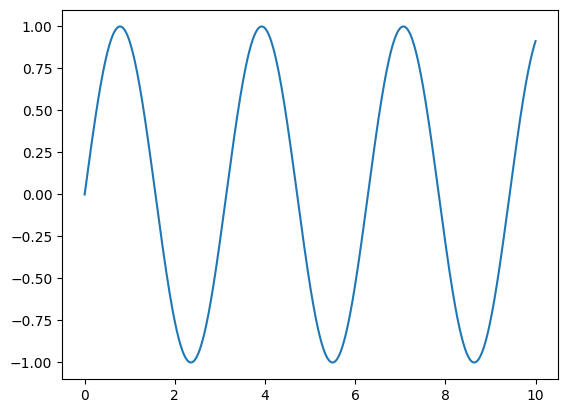

In [3]:
# Fact 1: JAX's syntax is remarkably similar to NumPy's
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [5]:
# Fact 2: JAX arrays are immutable! (embrace the functional programming paradigm)

size = 10
index = 0
value = 23

# NumPy mutable arrays
x = jnp.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [6]:
y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [7]:
# Fact 3: JAX handles random numbers differently
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))
print(type(x), x)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [8]:
# Fact 4: JAX is AI accelerator agnostic. Some code runs everywhere!

size = 3000

x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()
%timeit np.dot(x_np, x_np.T)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()

x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()

13.4 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
320 ms ± 95.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
61.9 ms ± 6.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.6 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## JAX transform functions

### `jit()` 101

In [9]:
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, n)
    y = fn(x)
    plt.plot(x, y); plt.show()

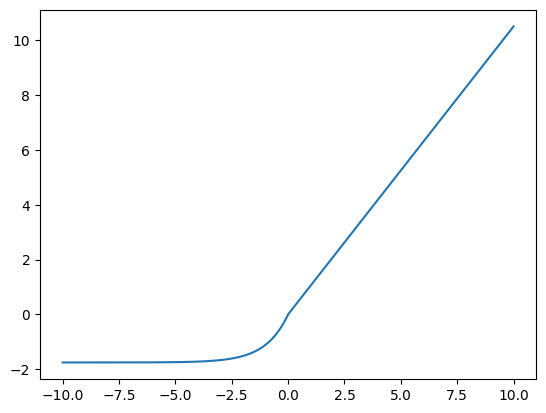

non-jit version:
1.17 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit version:
153 µs ± 39.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)

visualize_fn(selu)

data = random.normal(key, (1000000, ))

print('non-jit version:')
%timeit selu(data).block_until_ready()

print('jit version:')
%timeit selu_jit(data).block_until_ready()

### `grad()` 101
Differentiation can be:

- manual
- symbolic
- numeric
- automatic!

In [11]:
def sum_logistic(x):
    return jnp.sum(x**2)

x = jnp.arange(3.)
loss = sum_logistic

grad_loss = grad(loss)

print(grad_loss(x))

[0. 2. 4.]


In [12]:
jnp.eye(len(x))

Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [13]:
def finite_differences(f, x):
    eps = 1e-3
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps) for v in jnp.eye(len(x))])

finite_differences(sum_logistic, x)

Array([0.       , 1.9998549, 3.9999483], dtype=float32)

In [14]:
x = 1.
y = 1.

f = lambda x, y: x**2 + x + 4 + y**2
# visualize_fn(f, l=-1, r=2, n=100)
# 2y
# 2x + 1
dfdx = grad(f)
dfdy = grad(f, argnums=1)  # 1
d2fdx = grad(dfdx)  # 2
d3fdx = grad(d2fdx) # 0

print(f(x, y))
print(dfdx(x, y))
print(dfdy(x, y))   # 2y
print(d2fdx(x, y))
print(d3fdx(x, y))

7.0
3.0
2.0
2.0
0.0


In [15]:
from jax import jacfwd, jacrev


f = lambda x, y: x**2 + y**2

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums=(0, 1)))

print(jacrev(f, argnums=(0, 1))(2., 2.))
print(hessian(f)(1., 1.))

(Array(4., dtype=float32, weak_type=True), Array(4., dtype=float32, weak_type=True))
((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


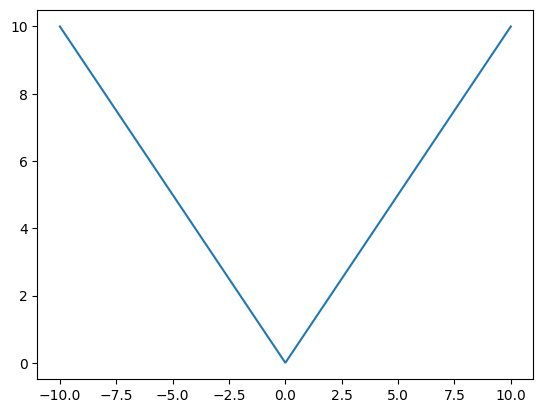

1 1
-1.0 1.0


In [16]:
f = lambda x: abs(x)
visualize_fn(f)

print(f(-1), f(1))
dfdx = grad(f)
print(dfdx(-1.), dfdx(0.))  # derivative at 0 is 1.

### `vmap()` 101

- Write your functions as if you were dealing with a single datapoint

In [17]:
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(W, x):
    return jnp.dot(W, x)

In [18]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print("Naive:")
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naive:


TypeError: apply_matrix() missing 1 required positional argument: 'x'

In [19]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)

print("Manually batched")
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
114 µs ± 18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
@jit
def vmap_batched_apply_matrix(W, batched_x):
    return vmap(apply_matrix, in_axes=(None, 0))(W, batched_x)

print("vmap")
%timeit vmap_batched_apply_matrix(W, batched_x).block_until_ready()

vmap
198 µs ± 87.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### How does JIT actually work?

In [21]:
def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

545 µs ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
220 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10, ), dtype=jnp.float32)
print(x)
print(get_negatives(x))

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]
[-0.3721109  -0.18252768 -0.7368197  -0.44030377 -0.1521442  -0.67135346
 -0.5908641 ]


In [24]:
jit(get_negatives)(x)

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [27]:
@jit
def f(x, y):
    print(x, y)
    result = jnp.dot(x + 1, y + 1)
    print(result)
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print("First call:")
print(f(x, y))

# not compile again
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print("Second call:")
print(f(x2, y2))

# compile again
x3 = np.random.randn(3, 5)
y3 = np.random.randn(5)
print("Third call:")
print(f(x3, y3))

First call:
Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[0.2855511 6.634348  6.1266394]
Second call:
[1.0635954 2.8393788 1.5804176]
Third call:
Traced<ShapedArray(float32[3,5])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[ 3.8150587 10.739914   9.554417 ]


In [28]:
def f(x, y):
    return jnp.dot(x + 1, y + 1)

print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


In [33]:
@jit
def f(x, neg):
    return -x if neg else x

f(1, True)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at <ipython-input-33-708cfe44bcda>:1 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [34]:
@jit
def f(x, neg):
    return jnp.where(neg, -x, x)  # Use jnp.where for conditional operations within jit

f(1, True)

Array(-1, dtype=int32, weak_type=True)

In [41]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

print(f(1, True))
print(f(2, True))
print(f(2, False))
print(f(23, False))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2
23


In [43]:
@jit
def f(x):
    print(x)
    print(x.shape)
    print(jnp.array(x.shape).prod)
    return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=1/0)>
(2, 3)
<bound method _forward_method_to_aval.<locals>.meth of Traced<ShapedArray(int32[2])>with<DynamicJaxprTrace(level=1/0)>>


TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function f at <ipython-input-43-21aabbf2fb1b>:1 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i32[2] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line <ipython-input-43-21aabbf2fb1b>:6 (f)

In [48]:
@jit
def f(x):
    print(x)
    print(x.shape)
    print(np.prod(x.shape))
    return x.reshape(np.prod(x.shape))

f(x)

Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=1/0)>
(2, 3)
6


Array([1., 1., 1., 1., 1., 1.], dtype=float32)

In [52]:
x = x + 1
f(x)

Array([4., 4., 4., 4., 4., 4.], dtype=float32)

# Gotcha #1: Pure functions

- JAX is designed to work only on pure functions!

Pure function:
1. All the input data is passed through the function parameters, all the results are output through the function results.
2. A pure function will always return the same result if invoked with the same inputs.

In [55]:
def impure_print_side_effect(x):
    print("Executing function") # Violating #1
    return x

# The side-effects appear during the first run
print("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compiled version of the function
print("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print("Third call, different type: ", jit(impure_print_side_effect)(jnp.ones((2, 3))))

Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [[1. 1. 1.]
 [1. 1. 1.]]


In [56]:
g = 0.

def impure_uses_globals(x):
    return x + g    # violating both #1 and #2

# JAX captures the value of the global during the first run
print("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global
g = 10.

# Subsequent runs may silently use the cached value of the globals
print("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print("Third call, different type: ", jit(impure_uses_globals)(jnp.ones((2, 3))))

First call:  4.0
Second call:  5.0
Third call, different type:  [[11. 11. 11.]
 [11. 11. 11.]]


In [58]:
@jit
def pure_uses_internal_state(x):

    state = dict(even=0, odd=0)
    for i in range(10):
        state['even' if i % 2 == 0 else 'odd'] += x

    return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(4.))

40.0


In [59]:
# lax.fori_loop; similarly for lax.scan, lax.cond, etc.
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i, x: x + array[i], 0))   # expected result 45

iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i, x: x + next(iterator), 0))

45
0
